In [3]:
import numpy as np
from numpy.linalg import eig
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import control as control
from scipy.integrate import simpson

from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.optimize import fsolve

In [76]:
#########
Y1 = 500 #polillas
Y2 = 500  #arboles
c = 50
tf = 10
#####

# P1

$\pmatrix{y_1 \\ y_2}' = \pmatrix{0 & 1 \\ -1 & 0} \pmatrix{y_1 \\ y_2} + \pmatrix{-1 \\ 0} u + \pmatrix{-Y_2 \\ Y_1}$ 
 
Se puede ver en el funcional a minimizar que $W = 0$, $U = 1$ y que $g(x(T)) = -y_1^2(T)$, es decir, $Q =  \pmatrix{1 & 0 \\ 0 & 0}$ 
Entonces, notando que $-A^T = A$, se puede escribir el sistema adjunto dado por Pontryagin como   
$\pmatrix{p_1 \\ p_2}' = \pmatrix{0 & 1 \\ -1 & 0} \pmatrix{p_1 \\ p_2}$ donde el gradiente de $g$ es $\pmatrix{2y_1 \\ 0}$. Así,   
$-1/2 \nabla g = \pmatrix{-y_1 \\ 0}$.   
 
Por último, en esta pregunta se trabaja con el sistema extendido (por bloques) de $(y,p)$ como:   
 
$\pmatrix{y \\ p}' = \pmatrix{A & 0 \\ 0 & A} \pmatrix{y \\ p} + \pmatrix{B \\ 0} u + \pmatrix{Y_{eq} \\ 0}$ donde $Y_{eq} = \pmatrix{-Y_2 \\ Y_1}$.   
 
Luego, por Pontryagin, el control óptimo es $u = U^{-1}Bp = \pmatrix{-1 & 0} \pmatrix{p_1 \\ p_2} = -p_1(t)$

In [77]:
A = np.array([[0,1],[-1,0]])
B = np.array([[-1,0]]).T
Q = np.array([[1,0],[0,0]])

Y = np.array([-Y2,Y1])

n = np.shape(A) # 2x2
o = np.zeros((2,1)) #vector de zeros

A1 = np.concatenate((A,np.zeros(n)))
A2 = np.concatenate((np.zeros(n),A), axis=0)  
Abar = np.concatenate((A1,A2), axis=1)
Bbar = np.concatenate((B,o)).reshape(-1) 
                      
r = np.array([-Y2,Y1,0,0])

In [78]:
def sistemaExtendido(t, x):  
    y1,y2,p1,p2 = x
    u=-p1
    return Abar@x + Bbar*u + r

In [79]:
## condición inicial

def f(p):
    p1,p2 = p
    x0 = np.array([Y1,Y2 + c,p1,p2]) 
    #time = np.linspace(0,1,100)
    P = solve_ivp(sistemaExtendido,[0,tf],x0,dense_output=True)
    y1 = P.y[0][-1] #P.sol(tf)[0]
    y2 = P.y[1][-1]  #P.sol(tf)[1]
    p1 = P.y[2][-1] #P.sol(tf)[2]
    p2 = P.y[3][-1] #P.sol(tf)[3]
    return [y1,y2,p1,p2]

def error(X):
    p1,p2= X #como condicion inicial p1(0),p2(0)
    return (f([p1,p2])[2] + f([p1,p2])[0])**2 + (f([p1,p2])[3])**2 # |y1+p1| + |p2|  

p_ini=minimize(error, x0=[2,4]).x

print("p_inicial" +str(p_ini))

p_inicial[63.41534461 41.42489849]


In [80]:
f(p_ini)

[75.74768308187153,
 469.28483950351995,
 -75.7476834353793,
 -1.7230841153903498e-07]

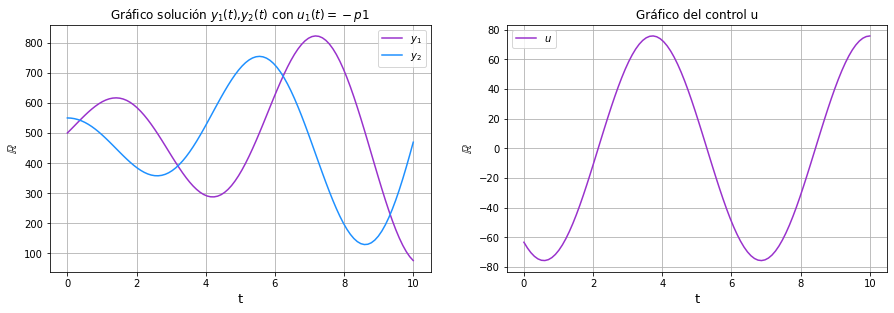

In [81]:
y_ini = np.array([Y1,Y2 + c,p_ini[0],p_ini[1]])  
Pf = solve_ivp(sistemaExtendido,[0,tf],y_ini,dense_output=True) 
time = np.linspace(0,tf,100) 
Pf_denso = Pf.sol(time) 
 
 
plt.figure(figsize=(15,10)) 
 
### estados ### 
 
plt.subplot(221) 
plt.plot(time,Pf_denso[0],c='darkorchid',label=r'$y_1$') 
plt.plot(time,Pf_denso[1],c='dodgerblue',label=r'$y_2$') 
plt.grid() 
plt.xlabel("t", size='13') 
plt.ylabel("$\mathbb{R}$", size='13') 
plt.title(r'Gráfico solución $y_1(t)$,$y_2(t)$ con $u_1(t) = -p1$') 
plt.legend() 
 
#### control #### 
 
plt.subplot(222) 
plt.plot(time,-Pf_denso[2],c='darkorchid',label=r'$u$') 
plt.grid() 
plt.xlabel("t", size='13') 
plt.ylabel("$\mathbb{R}$", size='13') 
plt.title(r'Gráfico del control u') 
plt.legend()

# P2

In [82]:
# se crean las matrices Q , R , N para utilizar el comando lqr

A2 = np.array([[0,1,0],[-1,0,0],[0,0,0]])
B2 = np.array([[-1,0,0]]).T

Q2 = np.array([[0,1,-Y2],[1,0,0],[-Y2,0,Y1**2]])
R = 1
N = np.array([[-1,0,0]]).T

K, S, E = control.lqr(A2, B2, Q2, R, N)


LinAlgError: Failed to find a finite solution.

# P3

In [83]:
def sistem_ricatti(t,X):
    e1,e2,e3,e4 = X # [e1,e2],[e3,e4]
    E = np.array([[e1,e2],[e3,e4]]) # se genera la matriz 
    E_prim = -A@E + E.T@A + (E.T@B)@(B.T@E) #Ecuacion de Ricatti pero para Eb(t) = E(T-t)
    return E_prim[0,0],E_prim[0,1],E_prim[1,0],E_prim[1,1]

y_ini = np.array([-1,0,0,0])  # condicion inicial de Ebar(0) = E(T) = -Q
Pfr = solve_ivp(sistem_ricatti,[0,tf],y_ini,dense_output=True)

In [84]:
ti = np.linspace(0,tf,1000)
J = Pfr.y
E0,E1,E2,E3 = Pfr.sol(ti)
e1f= E0[::-1]
e2f= E1[::-1]


In [85]:
# Se hace el sistema como edpn, discretizando
def edp(e1,e2):
    y1 = [Y1]
    y2 = [Y2 + c]
    delt = tf/1000
    for t in range(1,len(e1)):
        y1.append(y1[t-1] + delt*(y2[t-1] - Y2 +e1[t]*y1[t-1] +e2[t]*y2[t-1]))
        y2.append(y2[t-1] + delt*(Y1 - y1[t-1]))
    return np.array(y1),np.array(y2)

In [86]:
y1 = edp(e1f,e2f)[0]
y2 = edp(e1f,e2f)[1]

u = -e1f*y1 - e2f*y2


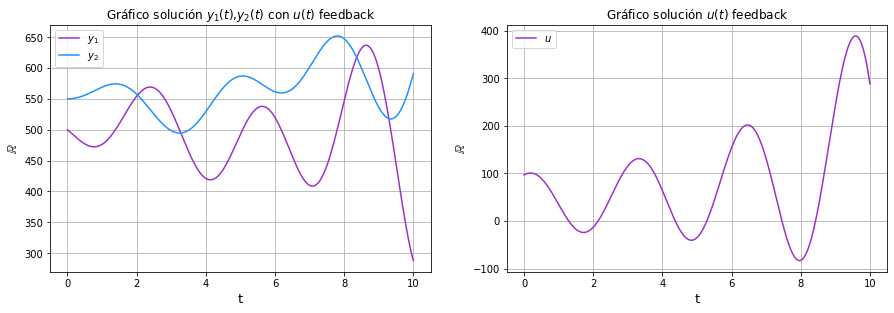

In [87]:
plt.figure(figsize=(15,10))

### estados ###

plt.subplot(221)
plt.plot(ti,y1,c='darkorchid',label=r'$y_1$')
plt.plot(ti,y2,c='dodgerblue',label=r'$y_2$')
plt.grid()
plt.xlabel("t", size='13')
plt.ylabel("$\mathbb{R}$", size='13')
plt.title(r'Gráfico solución $y_1(t)$,$y_2(t)$ con $u(t)$ feedback')
plt.legend()

### control ### 

plt.subplot(222)
plt.plot(ti,u,c='darkorchid',label=r'$u$')
plt.grid()
plt.xlabel("t", size='13')
plt.ylabel("$\mathbb{R}$", size='13')
plt.title(r'Gráfico solución $u(t)$ feedback')
plt.legend()
plt.savefig("Y1Y2510.png")

In [88]:
integral1 = simpson(np.square(Pf_denso[2]), time) 
print('Valor objetivo: ', (Pf_denso[0][-1])**2 + integral1)

Valor objetivo:  35752.219698722474


In [89]:
integral2 = simpson(np.square(u), ti) 
print('Valor objetivo: ', (y1[-1])**2 + integral2)

Valor objetivo:  284784.85946437554


# P4 
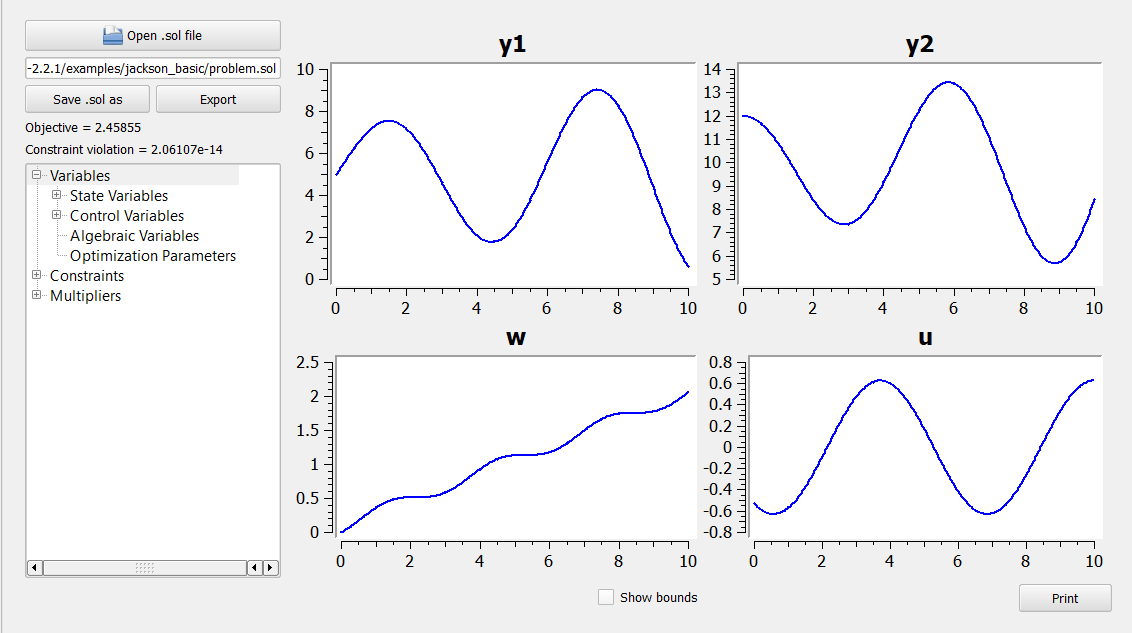

# P5 
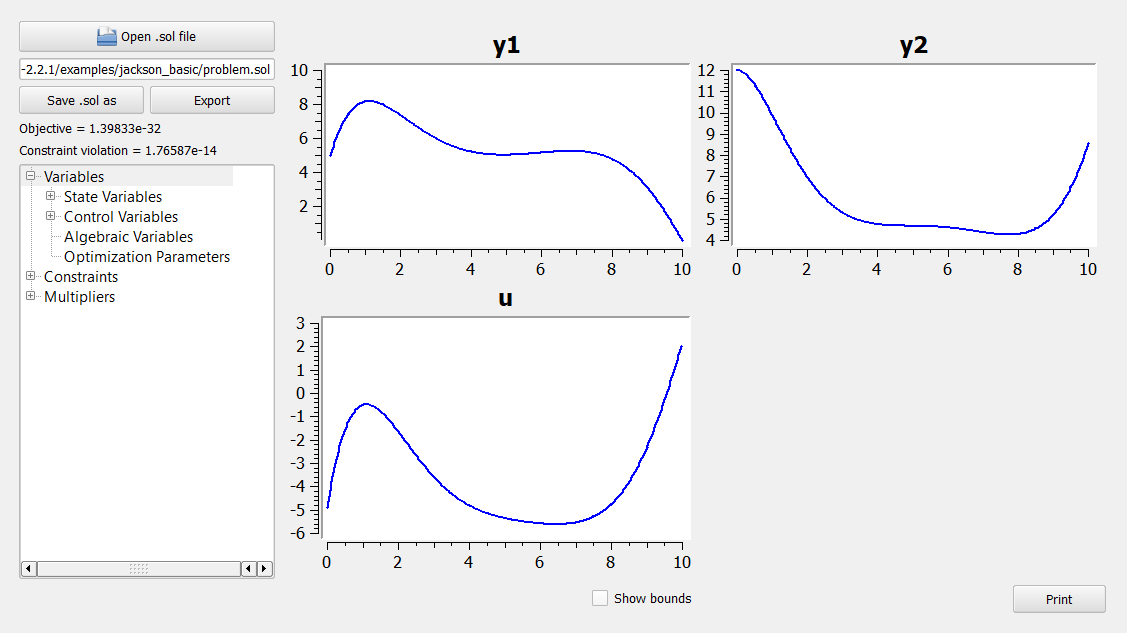